<a href="https://colab.research.google.com/github/ProfessorQu/Reinforcement-Learning/blob/main/Exercise_2_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2.11
Make a figure analogous to Figure 2.6 for the nonstationary
case outlined in Exercise 2.5. Include the constant-step-size epsilon-greedy algorithm with
alpha= 0.1. Use runs of 200,000 steps and, as a performance measure for each algorithm and
parameter setting, use the average reward over the last 100,000 steps.

## Summary
Make a graph with these bandits:
- Sample average ε-greedy;
- Constant step size ε-greedy with alpha = 0.1;
- Upper Bound Confidence (UBC);
- Gradient bandit;
- ε-greedy with optimistic initialization (e.g. q*(a) = 5 for all a) with alpha = 0.1;

### Implementation
I used NumPy arrays for the bandits, so each bandit has it's own Q(a), I did this because then I would only need one object and calculating stuff with arrays is quite faster than having to loop over all the Bandit objects and change their values seperatly.

In [ ]:
# Imports and initialization
import numpy as np
import matplotlib.pyplot as plt

k = 10  # Number of arms (actions)
m = 200 # Number of bandits (agents)

steps = 20000 # The number of steps for the simulation

true_R = np.zeros(k) # The q* (the actual values of the rewars)

parameters = [2**i for i in range(-7, 3)] # The parameters to try

# Print out the variables
print("k:", k)
print("m:", m)
print("steps:", steps)
print("true_R:", true_R)
print("parameters:", parameters)

k: 10
m: 200
steps: 20000
true_R: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
parameters: [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4]


In [ ]:
class Bandit(object):
  """
  The base bandit class
  """
  def __init__(self, m, k, epsilon=0.1, alpha=None, init_Q=None):
      # Initialize all the variables
      assert isinstance(alpha, (int, float)) or callable(alpha) or alpha is None, f"{alpha} is not an int, float, function or None"
      assert isinstance(epsilon, (int, float)), f"{epsilon} is not an int or float"

      self.epsilon = epsilon

      if epsilon > 1:
        self.epsilon = 1
      elif epsilon < 0:
        self.epsilon = 0

      self.k = k # Num actions
      self.m = m # Num bandits

      self.N = np.zeros((self.m, self.k)) # How many times a certain action was chosen
      self.Q = np.zeros((self.m, self.k)) # What we think is the current value of each action

      if init_Q is not None:
        for row in range(m):
          self.Q[row, :] = init_Q

      if isinstance(alpha, (int, float)):
        self.alpha = lambda i, a: alpha
      elif callable(alpha):
        self.alpha = alpha
      elif alpha is None:
        self.alpha = lambda i, a: 1 / self.N[i, a]
    
  def _choose_action(self):
    pass
  
  def step(self):
    pass


In [ ]:
class EpsilonBandit(Bandit):
  """
  The bandit for ε-greedy algorithms
  """
  def __init__(self, m, k, epsilon=0.1, alpha=None, init_Q=None):
    # Initialize
    super().__init__(m, k, epsilon=epsilon, alpha=alpha, init_Q=init_Q)
    
  def _choose_action(self) -> int:
    """
    Choose an action

    if some random number < epsilon --> choose a random action
    else --> choose the 'best' action (according to our Q(a))
    """
    A = [np.argmax(row) if np.random.binomial(1, self.epsilon) == 0
         else np.random.randint(self.k) for row in self.Q[:, ]]
    
    return A
  
  def step(self, t) -> int:
    # Choose the actions and return the reward
    A = self._choose_action()

    R = np.zeros((self.m))
    
    for i, a in enumerate(A):
      R[i] += true_R[a]
      self.N[i, a] += 1
      self.Q[i, a] += self.alpha(i, a) * (true_R[a] - self.Q[i, a])    

    return R

In [ ]:
class UBCBandit(Bandit):
  """
  The bandit for Upper Bound Confidence algorithms
  """
  def __init__(self, m, k, c=0.1, epsilon=0.1, alpha=None, init_Q=None):
    # Initialize
    assert isinstance(c, (int, float)), f"{c} is not an int or float"

    self.c = c

    super().__init__(m, k, epsilon=epsilon, alpha=alpha, init_Q=init_Q)
  
  def _choose_action(self, t) -> int:
    """
    Choose an action according to

    argmax( Q(a) + c * sqrt(ln(t) / N(a)) )
    """
    A = [np.argmax(row + self.c * np.sqrt(np.log(t + 1) / (n + 1)))
         if np.random.binomial(1, self.epsilon) == 0
         else np.random.randint(self.k) for row, n in zip(self.Q[:, ], self.N[:, ])]

    return A

  def step(self, t) -> int:
    # Choose the actions and return the reward
    A = self._choose_action(t)

    R = np.zeros((self.m))
    
    for i, a in enumerate(A):
      R[i] += true_R[a]
      self.N[i, a] += 1
      self.Q[i, a] += self.alpha(i, a) * (true_R[a] - self.Q[i, a])    

    return R

In [ ]:
class GradientBandit(object):
  def __init__(self, m, k, alpha=None):
    # Initialize
    assert isinstance(alpha, (int, float)) or callable(alpha) or alpha is None, f"{alpha} is not an int, float, function or None"

    self.m = m
    self.k = k

    self.H = np.zeros((m, k))

    if isinstance(alpha, (int, float)):
        self.alpha = lambda i, a: alpha
    elif callable(alpha):
      self.alpha = alpha
    elif alpha is None:
      self.alpha = lambda i, a: 1 / self.N[i, a]

  def _choose_action(self) -> int:
    """
    Choose an action according to

    Calculate for all action a in A:
    e^a / sum(e^A)

    Choose a random action with those probabilities
    """
    A_prob = [np.exp(row) / np.sum(np.exp(row)) for row in self.H[:, ]]
    A = [np.random.choice(np.arange(self.k), p=p) for p in A_prob]

    return A, A_prob
  
  def step(self, t) -> int:
    # Choose the actions and return the reward
    A, A_prob = self._choose_action()
    R = [true_R[a] for a in A]
    
    for i, a in enumerate(A):
      self.H[i, :] += self.alpha(i, a) * R[i] * (GradientBandit.one_hot(a, self.k) - A_prob[i])

    return R
      
  @staticmethod
  def one_hot(position, length):
    """
    Returns a length array where position is 1 and the rest is 0
    """
    oh = np.zeros(length)
    oh[position] = 1

    return oh

Streaminguitvoer ingekort tot de laatste 5000 regels.
Param 10/10 Step 15001/20000
Param 10/10 Step 15002/20000
Param 10/10 Step 15003/20000
Param 10/10 Step 15004/20000
Param 10/10 Step 15005/20000
Param 10/10 Step 15006/20000
Param 10/10 Step 15007/20000
Param 10/10 Step 15008/20000
Param 10/10 Step 15009/20000
Param 10/10 Step 15010/20000
Param 10/10 Step 15011/20000
Param 10/10 Step 15012/20000
Param 10/10 Step 15013/20000
Param 10/10 Step 15014/20000
Param 10/10 Step 15015/20000
Param 10/10 Step 15016/20000
Param 10/10 Step 15017/20000
Param 10/10 Step 15018/20000
Param 10/10 Step 15019/20000
Param 10/10 Step 15020/20000
Param 10/10 Step 15021/20000
Param 10/10 Step 15022/20000
Param 10/10 Step 15023/20000
Param 10/10 Step 15024/20000
Param 10/10 Step 15025/20000
Param 10/10 Step 15026/20000
Param 10/10 Step 15027/20000
Param 10/10 Step 15028/20000
Param 10/10 Step 15029/20000
Param 10/10 Step 15030/20000
Param 10/10 Step 15031/20000
Param 10/10 Step 15032/20000
Param 10/10 Step 1

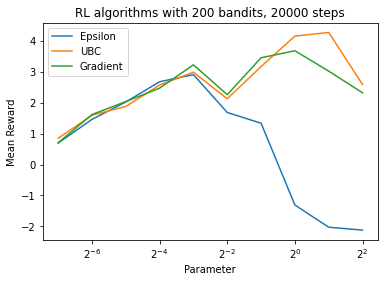

In [ ]:
eps_mean_r = []
ubc_mean_r = []
grad_mean_r = []

# Run for all parameters
for param in parameters:
  # Create a list of Epsilon Bandit, UBC Bandit and Gradient Bandit
  bandits = [
    EpsilonBandit(m, k, epsilon=param, alpha=0.1), # ε = param
    UBCBandit(m, k, c=param, epsilon=0.1, alpha=0.1), # c = param
    GradientBandit(m, k, alpha=param) # α = param
  ]

  # Generate a few lists
  x = [i for i in range(steps)]
  r = [np.zeros(steps) for _ in range(len(bandits))]

  # Run the simulation with the current param
  for t in range(steps):
    for i, bandit in enumerate(bandits):
      R = bandit.step(t)
      r[i][t] = np.mean(R)

    # Add a normal distribution
    true_R += np.random.normal(0, 0.01, k)
    
    print(f"Param {parameters.index(param) + 1}/{len(parameters)} Step {t + 1}/{steps}")
  
  eps_mean_r.append(np.mean(r[0][: steps // 2]))
  ubc_mean_r.append(np.mean(r[1][: steps // 2]))
  grad_mean_r.append(np.mean(r[2][: steps // 2]))

# Plot the results
plt.plot(parameters, eps_mean_r, label="Epsilon")
plt.plot(parameters, ubc_mean_r, label="UBC")
plt.plot(parameters, grad_mean_r, label="Gradient")

plt.xscale('log', basex=2)

plt.title(f"RL algorithms with {m} bandits, {steps} steps")
plt.xlabel("Parameter")
plt.ylabel("Mean Reward")

plt.legend()

# Save the plot
plt.savefig("drive/MyDrive/Colab Notebooks/RL book exercises/2_11.png", dpi=300)

plt.show()